In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [7]:
list_null = df[df.columns[df.isnull().sum() > 0].to_list()]

In [9]:
list_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Sulfate          2495 non-null   float64
 2   Trihalomethanes  3114 non-null   float64
dtypes: float64(3)
memory usage: 76.9 KB


In [12]:
df.loc[df['ph'].isnull(), 'ph'] = df['ph'].mean()
df.loc[df['Sulfate'].isnull(), 'Sulfate'] = df['Sulfate'].mean()
df.loc[df['Trihalomethanes'].isnull(), 'Trihalomethanes'] = df['Trihalomethanes'].mean()

In [15]:
list_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Empty DataFrame

<AxesSubplot:>

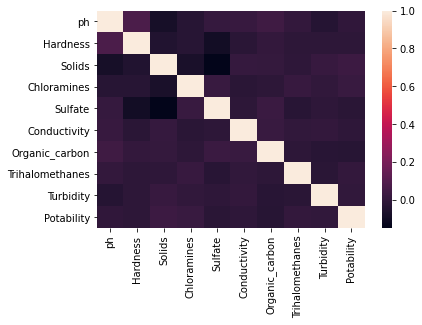

In [18]:
corr = df.corr(method='pearson')
sns.heatmap(corr)

In [38]:
threshold = 0.8
def correlation():
    for i in df.columns:
        for j in df.columns[list(df.columns).index(i) + 1:]:
            if abs(pearsonr(df[i], df[j])[0]) >= threshold:
                 yield (pearsonr(df[i], df[j])[0], i, j)

In [39]:
corr_list = list(correlation())
corr_list

[]

In [43]:
X = df.drop("Potability", axis=1)
y = df['Potability']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
logi_regression = LogisticRegression()

In [48]:
logi_regression.fit(X_train, y_train)

LogisticRegression()

In [49]:
predict_l2 = logi_regression.predict(X_test)

In [50]:
accuracy_score(y_test, predict_l2)

0.6284658040665434

In [53]:
logi_regression_l1 = LogisticRegression(penalty='none')

In [54]:
logi_regression_l1.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [56]:
predict_none = logi_regression_l1.predict(X_test)

In [58]:
accuracy_score(y_test, predict_none)

0.6284658040665434

In [61]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
forest_pred = rand_forest.predict(X_test)

In [64]:
accuracy_score(y_test, forest_pred)

0.6654343807763401

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
forest_cv = cross_val_score(rand_forest, X, y, cv=10, scoring='roc_auc')

In [76]:
print(forest_cv)

[0.66462891 0.53378906 0.67046875 0.66083984 0.67951172 0.52628906
 0.52698819 0.64401575 0.63450063 0.67782271]


In [77]:
print(forest_cv.mean())

0.621885461618501


In [67]:
confusion_matrix(y_test, forest_pred)

array([[591,  89],
       [273, 129]], dtype=int64)

In [69]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.68      0.87      0.77       680
           1       0.59      0.32      0.42       402

    accuracy                           0.67      1082
   macro avg       0.64      0.60      0.59      1082
weighted avg       0.65      0.67      0.64      1082



In [71]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
forest_random = RandomizedSearchCV(estimator=rand_forest,
                                  param_distributions=random_grid,
                                  n_iter= 100,
                                  cv= 3,
                                  verbose= 2,
                                  random_state=42,
                                  n_jobs= -1)
forest_random.fit(X_train, y_train)
print(forest_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.7min finished


{'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': 500}


In [72]:
rand_forest_optimized = RandomForestClassifier(n_estimators=600, max_features= 'sqrt', max_depth=500)

In [73]:
rand_forest_optimized.fit(X_train, y_train)

RandomForestClassifier(max_depth=500, max_features='sqrt', n_estimators=600)

In [74]:
optimized_pred = rand_forest_optimized.predict(X_test)

In [78]:
optimized_cv = cross_val_score(rand_forest_optimized, X, y, cv=10, scoring='roc_auc')

In [79]:
print(optimized_cv)

[0.67208984 0.5428125  0.67765625 0.68228516 0.66929688 0.52947266
 0.5486811  0.64874016 0.65420854 0.67660568]


In [80]:
print(optimized_cv.mean())

0.6301848768479454


In [81]:
accuracy_score(y_test, optimized_pred)

0.6829944547134935